In [ ]:
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
!tar -xzf testSetPlaces205_resize.tar.gz

--2022-05-12 19:28:18--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘testSetPlaces205_resize.tar.gz’

              testS  45%[========>           ]   1019M   931KB/s    eta 23m 0s ^C
^C


In [ ]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if i < 1000: # first 1000 will be val
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  else: # others will be val
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

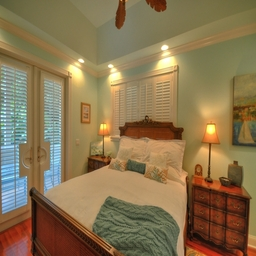

In [ ]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename='images/val/class/0138c570e2b36d931e0e484f456243ee.jpg'))

In [ ]:
# Download and import libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow

In [ ]:
pip install torchvision

In [ ]:
#!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
from torchvision import models 
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [ ]:
resnet=models.resnet18()
resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
midlevel_resnet 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

ResNet18(1, ResBlock)

ResNet18(
  (layer0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet()

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 50

In [ ]:
!pip3 install --upgrade Pillow

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

In [ ]:
model.state_dict()

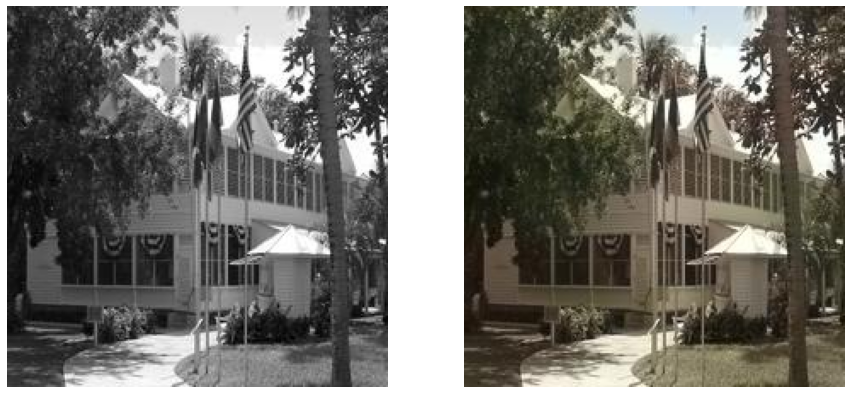

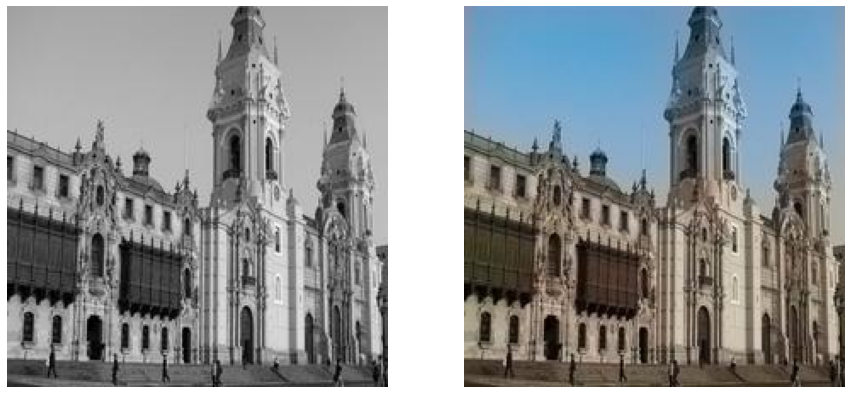

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-4-epoch-10.jpg', 'outputs/gray/img-4-epoch-10.jpg'),
               ('outputs/color/img-1-epoch-10.jpg', 'outputs/gray/img-1-epoch-10.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-1-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.532 (1.532)	Loss 0.2863 (0.2863)	
Finished validation.


0.2827994968891144

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-18-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 18)
losses

Validate: [0/16]	Time 1.483 (1.483)	Loss 0.2497 (0.2497)	
Finished validation.


0.247973198056221

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-2-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.468 (1.468)	Loss 0.2642 (0.2642)	
Finished validation.


0.2612108221054077

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-23-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.521 (1.521)	Loss 0.2899 (0.2899)	
Finished validation.


0.28717456102371214

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-26-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.757 (1.757)	Loss 0.2814 (0.2814)	
Finished validation.


0.27908602261543275

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-29-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 2.015 (2.015)	Loss 0.3250 (0.3250)	
Finished validation.


0.3220686323642731

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-31-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.506 (1.506)	Loss 0.2754 (0.2754)	
Finished validation.


0.27302667713165285

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-34-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.509 (1.509)	Loss 0.2701 (0.2701)	
Finished validation.


0.26702461671829225

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-35-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.491 (1.491)	Loss 0.3183 (0.3183)	
Finished validation.


0.315522926568985

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-6-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.473 (1.473)	Loss 0.2796 (0.2796)	
Finished validation.


0.27648071002960206

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a new model instance
model = ColorizationNet('./checkpoints/model-epoch-8-losses-0.003.pth')

if torch.cuda.is_available():
    model.cuda()

# Evaluate the model
losses = validate(val_loader, model, criterion, save_images, 1)
losses

Validate: [0/16]	Time 1.457 (1.457)	Loss 0.2526 (0.2526)	
Finished validation.


0.2506919974088669

<Figure size 432x288 with 0 Axes>

In [ ]:
model_epochs = [1,18,2,23,26,29,31,34,35,6,8]
times = [1.532, 1.483, 1.468, 1.521, 1.757, 2.015, 1.506, 1.509, 1.491, 1.473, 1.457]
all_losses = [0.2863, 0.2497, 0.2642, 0.2899, 0.2814, 0.3250, 0.2754, 0.2701, 0.3183, 0.2796, 0.2526]

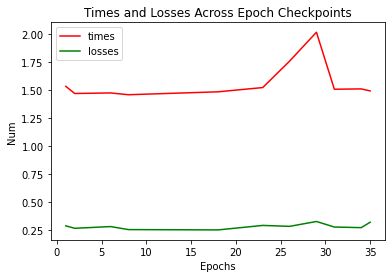

In [ ]:
model_epochs = [1, 2, 6, 8, 18, 23, 26, 29, 31, 34, 35]
times = [1.532, 1.468, 1.473, 1.457, 1.483, 1.521, 1.757, 2.015, 1.506, 1.509, 1.491]
all_losses = [0.2863, 0.2642, 0.2796, 0.2526, 0.2497, 0.2899, 0.2814, 0.3250, 0.2754, 0.2701, 0.3183]
plt.plot(model_epochs, times, color='red', label='times')
plt.plot(model_epochs, all_losses, color='green', label='losses')
plt.title('Times and Losses Across Epoch Checkpoints')
plt.xlabel('Epochs')
plt.ylabel('Num')
plt.legend()
plt.show()

In [ ]:
min(all_losses) # at 18

0.2497

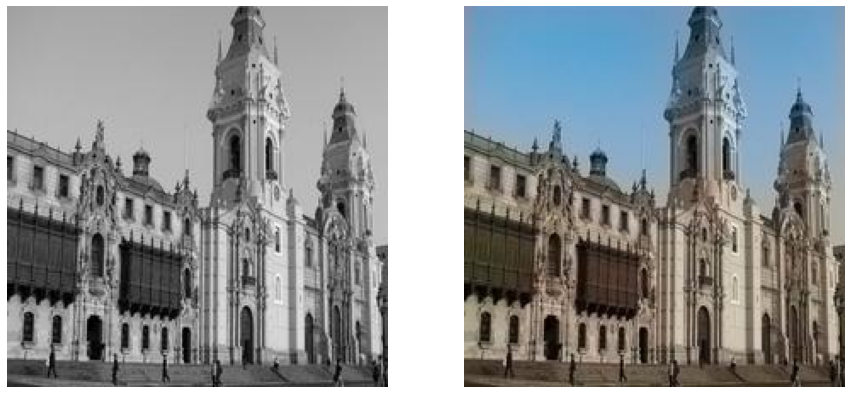

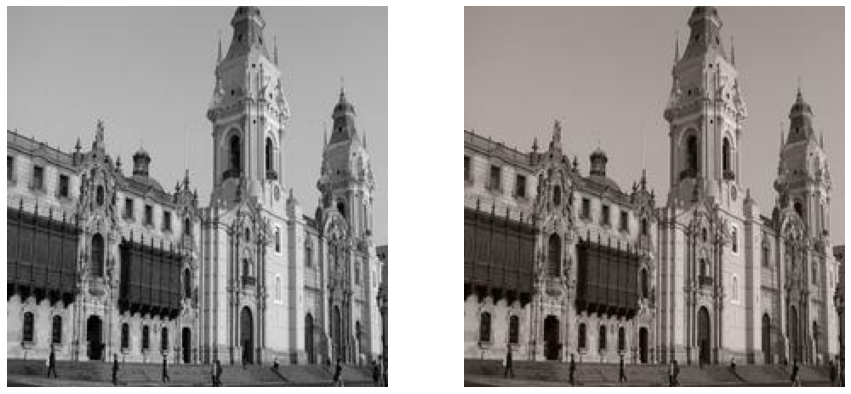

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-1-epoch-10.jpg', 'outputs/gray/img-1-epoch-18.jpg'),
               ('outputs/color/img-1-epoch-49.jpg', 'outputs/gray/img-1-epoch-49.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()